In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline
from datasets import load_dataset

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import tqdm
import json
import random

In [2]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased-whole-word-masking")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-large-uncased-whole-word-masking")
pipe = pipeline("fill-mask", model="google-bert/bert-large-uncased-whole-word-masking")

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you a

In [3]:
def GetOriginalModel() -> nn.Module:
    return AutoModelForMaskedLM.from_pretrained("google-bert/bert-large-uncased-whole-word-masking")

model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

In [4]:
print("Overall parameter count:", model.num_parameters())
print("Attention weight parameter count:", 1024 * 1024 * 3 * 24)
print("Attention weight parameter ratio:", 1024 * 1024 * 3 * 24 / model.num_parameters())

Overall parameter count: 335174458
Attention weight parameter count: 75497472
Attention weight parameter ratio: 0.22524828547645478


In [5]:
weights_query_matrices = []
weights_key_matrices = []
weights_value_matrices = []

NUM_ATTENTION_LAYERS = 24

for i in tqdm.tqdm(range(NUM_ATTENTION_LAYERS)):
    weights_query_matrices.append(model.bert.encoder.layer[i].attention.self.query.weight.detach().numpy())
    weights_key_matrices.append(model.bert.encoder.layer[i].attention.self.key.weight.detach().numpy())
    weights_value_matrices.append(model.bert.encoder.layer[i].attention.self.value.weight.detach().numpy())

weights_query_variance_ratio = []
weights_key_variance_ratio = []
weights_value_variance_ratio = []

for i in tqdm.tqdm(range(NUM_ATTENTION_LAYERS)):
    weights = weights_query_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_query_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

    weights = weights_key_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_key_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

    weights = weights_value_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_value_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

  4%|▍         | 1/24 [00:52<19:59, 52.17s/it]


KeyboardInterrupt: 

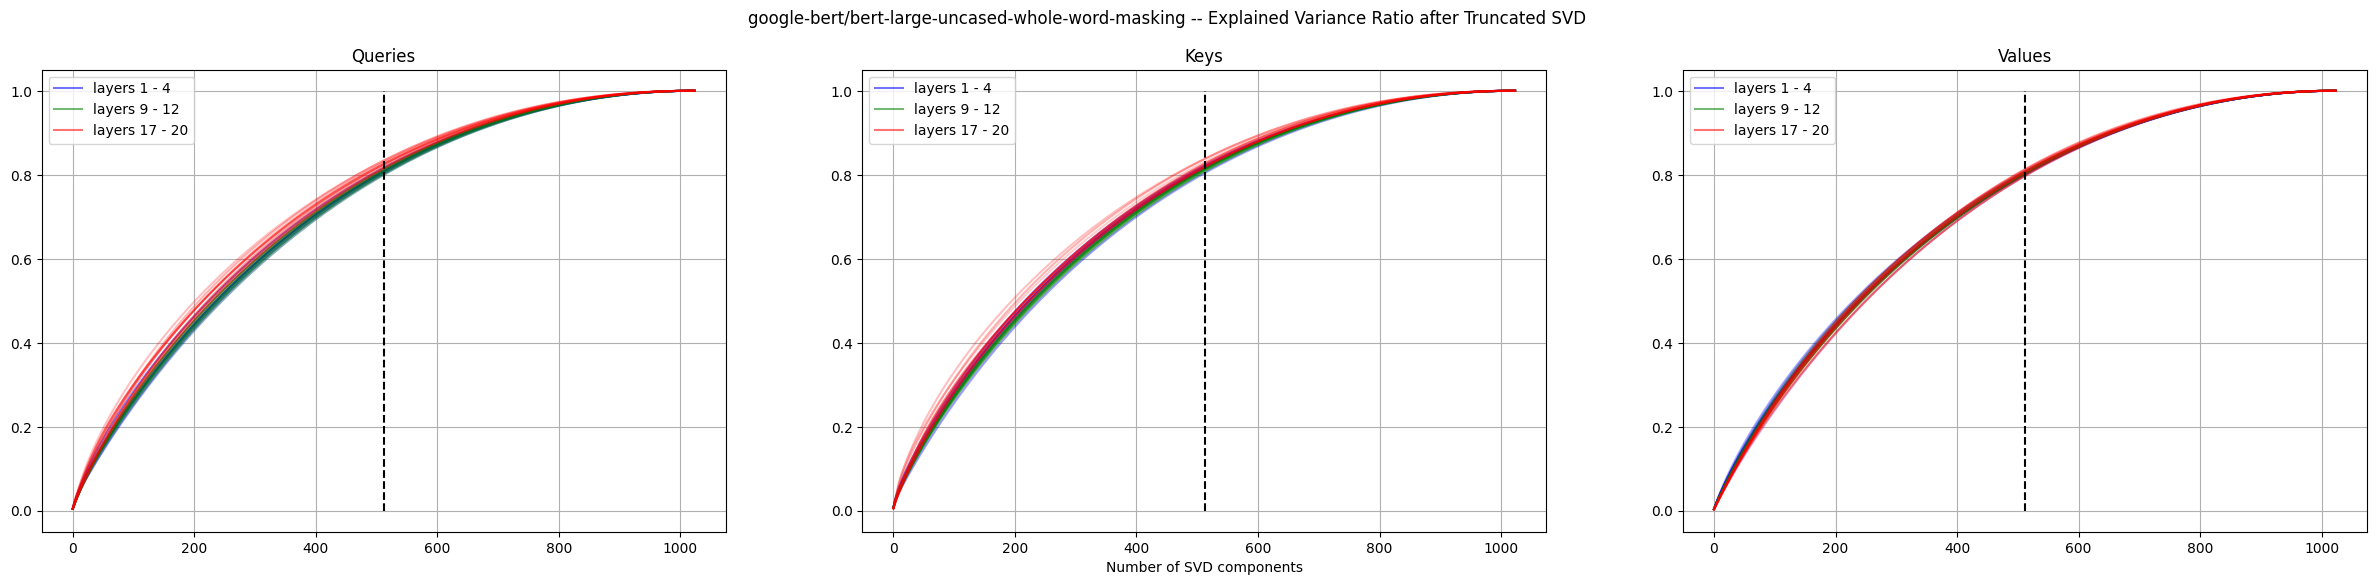

In [6]:
colors = ['blue', 'green', 'red']
titles = ['Queries', 'Keys', 'Values']

weights_variance_ratio = [weights_query_variance_ratio, weights_key_variance_ratio, weights_value_variance_ratio]

layers_per_color = 8

plt.figure(figsize=(30, 6))

for j in range(3):
    plt.subplot(1, 3, j + 1)
    for i in range(NUM_ATTENTION_LAYERS):
        if i % layers_per_color == layers_per_color - 1:
            layer_num = i // layers_per_color
            plt.plot(weights_variance_ratio[j][i], alpha=0.2 + (i % layers_per_color) * 0.05,
                     color=colors[i // layers_per_color],
                     label=f"layers {layers_per_color * layer_num + 1} - {layers_per_color * layer_num + 4}")
        else:
            plt.plot(weights_variance_ratio[j][i], alpha=0.2 + (i % layers_per_color) * 0.05, color=colors[i // layers_per_color])

    plt.vlines(len(weights_variance_ratio[0][0]) // 2, ymin=0, ymax=1, linestyle='--', color='black')

    plt.title(titles[j])
    plt.legend()
    plt.grid()

    if j == 1:
        plt.xlabel('Number of SVD components')

plt.suptitle('google-bert/bert-large-uncased-whole-word-masking -- Explained Variance Ratio after Truncated SVD')

plt.show()

In [5]:
dataset = load_dataset("nyu-mll/multi_nli")

In [6]:
dataset = dataset['validation_matched']

In [7]:
model.eval()


def mask_tokens(text, mask_prob=0.1):
    tokens = tokenizer.tokenize(text)
    masked_tokens = tokens.copy()
    masked_originals = []
    for i in range(min(len(tokens), 512)):
        if random.random() < mask_prob and tokens[i] not in tokenizer.all_special_tokens and len(masked_originals) < 5:
            masked_tokens[i] = "[MASK]"
            masked_originals.append(tokens[i])
    return masked_tokens, masked_originals


def evaluate_mask_filling(dataset, device):
    correct = 0
    total = 0
    model.to(device)

    for example in tqdm.tqdm(dataset):
        text = example['premise'].strip()

        masked_tokens, masked_originals = mask_tokens(text)
        if not masked_originals:
            continue

        masked_text = " ".join(masked_tokens)
        outputs = pipe(masked_text)
        if not isinstance(outputs[0], list):
            outputs = [outputs]

        for j, original_token in enumerate(masked_originals):
            for word in outputs[j]:
                if word['token_str'] == original_token:
                    correct += 1
                total += 1

    accuracy = correct * 5 / total if total > 0 else 0
    return {"mask_filling_accuracy": accuracy, "total_predictions": total, "nun_parameters": model.num_parameters()}


#results = evaluate_mask_filling(dataset)
#print("Evaluation results:", results)

In [12]:
with open('bert-accuracy-scores/original_model.json', 'w') as file:
    json.dump(results, file, indent=4)

In [8]:
class TruncatedSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: torch.Tensor, bias: torch.Tensor, device: torch.device = torch.device('cpu')):
        super().__init__()
        U, Sigma, V = torch.linalg.svd(weight, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = torch.diag(Sigma[:min(rank, max_rank)])
        U = U[:, :min(rank, max_rank)] @ SigmaDiag
        V = V[:min(rank, max_rank), :]

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(U)
        self.U.bias.data.copy_(bias)
        self.V.weight.data.copy_(V)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'

In [9]:
def MakeModifiedModel(
    model: nn.Module,
    max_rank: int,
    max_layer: int,
    all_layers: int,
    device: torch.device = torch.device('cpu'),
) -> nn.Module:
    for i in range(min(max_layer, all_layers)):
        print(i)
        model.bert.encoder.layer[i].attention.self.query = TruncatedSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.query.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.query.bias.detach(),
            device=device
        )
        model.bert.encoder.layer[i].attention.self.key = TruncatedSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.key.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.key.bias.detach(),
            device=device
        )
        model.bert.encoder.layer[i].attention.self.value = TruncatedSVDLinear(
            rank=max_rank,
            weight=model.bert.encoder.layer[i].attention.self.value.weight.detach(),
            bias=model.bert.encoder.layer[i].attention.self.value.bias.detach(),
            device=device
        )

    return model.to(device)


def MakeModifiedPipe(max_rank: int, max_layer: int, all_layers: int, device: torch.device) -> pipeline:
    pipe_modified = pipeline(
        "fill-mask",
        model=MakeModifiedModel(GetOriginalModel(), max_rank, max_layer, all_layers, device),
        tokenizer=tokenizer,
        device=device
    )
    return pipe_modified

In [10]:
def evaluate_piped_mask_filling(pipeline, dataset, device):
    correct = 0
    total = 0
    model.to(device)
    #dataset = dataset.to(device)

    for example in tqdm.tqdm(dataset):
        text = example['premise'].strip()

        masked_tokens, masked_originals = mask_tokens(text)
        if not masked_originals:
            continue

        masked_text = " ".join(masked_tokens)
        outputs = pipeline(masked_text)
        if not isinstance(outputs[0], list):
            outputs = [outputs]

        for j, original_token in enumerate(masked_originals):
            for word in outputs[j]:
                if word['token_str'] == original_token:
                    correct += 1
                total += 1

    accuracy = correct * 5 / total if total > 0 else 0
    return {"mask_filling_accuracy": accuracy, "total_predictions": total, "nun_parameters": model.num_parameters()}

In [64]:
max_rank = 256
NUM_ATTENTION_LAYERS = 24
all_layers = NUM_ATTENTION_LAYERS

In [65]:
for max_layer in range(10, 25, 2):
    print(f'max_layer#{max_layer}')
    device = torch.device('cuda:0')
    model = GetOriginalModel()
    modified_model = MakeModifiedModel(model, max_rank, max_layer, all_layers, device)
    pipe_modified = pipeline(
        "fill-mask",
        model=modified_model,
        tokenizer=tokenizer,
        device=device
    )

    print(f'pipeline#{max_layer}')
    results = evaluate_piped_mask_filling(pipe_modified, dataset, device)
    print(f'results#{max_layer}')
    with open(f'bert-accuracy-scores/truncated-model-256-{max_layer}.json', 'w') as file:
        json.dump(results, file, indent=4)

max_layer#10


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9


Device set to use cuda:0


pipeline#10


100%|██████████| 9815/9815 [03:55<00:00, 41.70it/s]


results#10
max_layer#12


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11


Device set to use cuda:0


pipeline#12


100%|██████████| 9815/9815 [04:01<00:00, 40.63it/s]


results#12
max_layer#14


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13


Device set to use cuda:0


pipeline#14


100%|██████████| 9815/9815 [04:01<00:00, 40.72it/s]


results#14
max_layer#16


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Device set to use cuda:0


pipeline#16


100%|██████████| 9815/9815 [03:56<00:00, 41.46it/s]


results#16
max_layer#18


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Device set to use cuda:0


pipeline#18


100%|██████████| 9815/9815 [04:02<00:00, 40.42it/s]


results#18
max_layer#20


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Device set to use cuda:0


pipeline#20


100%|██████████| 9815/9815 [04:14<00:00, 38.56it/s]


results#20
max_layer#22


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Device set to use cuda:0


pipeline#22


100%|██████████| 9815/9815 [04:17<00:00, 38.05it/s]


results#22
max_layer#24


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Device set to use cuda:0


pipeline#24


100%|██████████| 9815/9815 [04:09<00:00, 39.26it/s]

results#24


In [11]:
max_rank = 128
NUM_ATTENTION_LAYERS = 24
all_layers = NUM_ATTENTION_LAYERS

for max_layer in range(24, 25, 2):
    print(f'max_layer#{max_layer}')
    device = torch.device('cuda:0')
    model = GetOriginalModel()
    modified_model = MakeModifiedModel(model, max_rank, max_layer, all_layers, device)
    pipe_modified = pipeline(
        "fill-mask",
        model=modified_model,
        tokenizer=tokenizer,
        device=device
    )

    print(f'pipeline#{max_layer}')
    results = evaluate_piped_mask_filling(pipe_modified, dataset, device)
    print(f'results#{max_layer}')
    with open(f'bert-accuracy-scores/truncated-model-128-{max_layer}.json', 'w') as file:
        json.dump(results, file, indent=4)

max_layer#24


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Device set to use cuda:0


pipeline#24


100%|██████████| 9815/9815 [03:49<00:00, 42.83it/s]

results#24


In [ ]:
def make_forward_pre_hook(module_number: int, statistics_dict: dict[int, list[torch.Tensor]]):
    def forward_pre_hook(module: torch.nn.Module, input):
        x = input[0]
        if module_number not in statistics_dict:
            statistics_dict[module_number] = []

        statistics_dict[module_number].append(x.detach().clone().cpu().numpy())

    return forward_pre_hook

model = GetOriginalModel()

handlers = []
attention_layers_preactivations = dict()

for i in range(NUM_ATTENTION_LAYERS):
    handler = model.bert.encoder.layer[i].attention.self.register_forward_pre_hook(
        make_forward_pre_hook(i, attention_layers_preactivations)
    )
    handlers.append(handler)


In [ ]:
def make_tokenization(text):
    return tokenizer.tokenize(text)

samples_count = 0
device = torch.device('cuda:0')

for example in dataset:
    text = example['premise'].strip()
    tokens = make_tokenization(text)
    if len(tokens) < 256:
        continue

    samples_count += 1
    tokens = tokens[:256]

    model.to(device)
    tokens = tokens.to(device)

    model(tokens)

In [ ]:
for handler in handlers:
    handler.remove()

In [ ]:
attention_layers_preactivations[0][0].shape